In [29]:
from dolfin import *
import numpy as np

%matplotlib inline
 

# Define input data
from ufl import SpatialCoordinate, inner, grad, lhs, rhs, dot, exp, Measure, dx, ds
from dolfin.fem import assemble_scalar

In [30]:
import dolfin
import dolfin.io
dolfin.__version__

'2018.2.0.dev0'

In [31]:
import meshio
# Read the file generated by gmsh
mesh = meshio.read("Models/poission_subdomain.msh")
points, cells, cell_data, field_data = mesh.points, mesh.cells, mesh.cell_data, mesh.field_data

In [32]:
field_data

{'LEFT': array([1, 1]),
 'TOP': array([2, 1]),
 'RIGHT': array([3, 1]),
 'BOTTOM': array([4, 1]),
 'DOMAIN': array([5, 2]),
 'OBSTACLE': array([6, 2])}

In [45]:
cells['line']

array([[ 0,  8],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [11,  3],
       [ 2, 12],
       [12, 13],
       [13, 14],
       [14, 15],
       [15,  1],
       [ 1, 16],
       [16, 17],
       [17, 18],
       [18, 19],
       [19,  0],
       [ 3, 26],
       [26, 27],
       [27,  6],
       [ 6,  7],
       [ 7, 28],
       [28,  2]])

In [33]:
cell_data

{'line': {'gmsh:physical': array([4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3])},
 'triangle': {'gmsh:physical': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 6, 6, 6, 6, 6])}}

In [34]:
meshio.write("Models/poisson_subdomain_mesh.xdmf", 
             meshio.Mesh(
                points=points[:,:2],# Converting to 2D
                cells={"triangle": cells["triangle"]},
                cell_data={"triangle": {"subdomain": cell_data["triangle"]["gmsh:physical"]}}
             )
            )

In [35]:
meshio.write("Models/poisson_subdomain_boundary.xdmf", meshio.Mesh(
    points=points[:,:2],# Converting to 2D
    cells={"line": cells["line"]},
    cell_data={"line": {"boundaries": cell_data["line"]["gmsh:physical"]}}
))

In [36]:
with dolfin.io.XDMFFile(dolfin.MPI.comm_world, "Models/poisson_subdomain_mesh.xdmf") as xdmf_infile:
    mesh = xdmf_infile.read_mesh(dolfin.MPI.comm_world, dolfin.cpp.mesh.GhostMode.none)
    mvc_subdomain = xdmf_infile.read_mvc_size_t(mesh, "subdomain")
domains = dolfin.cpp.mesh.MeshFunctionSizet(mesh, mvc_subdomain, 1)

In [37]:
with dolfin.io.XDMFFile(dolfin.MPI.comm_world, "Models/poisson_subdomain_boundary.xdmf") as xdmf_infile:
    mvc_boundaries = xdmf_infile.read_mvc_size_t(mesh, "boundaries")
boundaries = dolfin.cpp.mesh.MeshFunctionSizet(mesh, mvc_boundaries, 0)

    #tags = xdmf_infile.read_tags()
#print(tags)

In [38]:
mvc_boundaries.values()

{(0, 1): 3,
 (3, 1): 2,
 (4, 1): 3,
 (5, 1): 4,
 (8, 1): 1,
 (9, 2): 1,
 (11, 1): 4,
 (18, 1): 3,
 (19, 1): 3,
 (21, 1): 4,
 (24, 1): 4,
 (25, 1): 1,
 (26, 1): 1,
 (27, 1): 2,
 (33, 1): 2,
 (35, 1): 2,
 (36, 1): 2,
 (39, 1): 4,
 (41, 1): 1,
 (52, 1): 3,
 (70, 1): 3}

In [39]:
mvc_subdomain.values()

{(0, 0): 5,
 (1, 0): 5,
 (2, 0): 5,
 (3, 0): 5,
 (4, 0): 5,
 (5, 0): 5,
 (6, 0): 5,
 (7, 0): 5,
 (8, 0): 5,
 (9, 0): 5,
 (10, 0): 5,
 (11, 0): 5,
 (12, 0): 5,
 (13, 0): 5,
 (14, 0): 5,
 (15, 0): 5,
 (16, 0): 5,
 (17, 0): 5,
 (18, 0): 5,
 (19, 0): 5,
 (20, 0): 5,
 (21, 0): 5,
 (22, 0): 5,
 (23, 0): 5,
 (24, 0): 5,
 (25, 0): 5,
 (26, 0): 5,
 (27, 0): 5,
 (28, 0): 5,
 (29, 0): 5,
 (30, 0): 5,
 (31, 0): 5,
 (32, 0): 5,
 (33, 0): 5,
 (34, 0): 5,
 (35, 0): 5,
 (36, 0): 5,
 (37, 0): 5,
 (38, 0): 5,
 (39, 0): 5,
 (40, 0): 5,
 (41, 0): 5,
 (42, 0): 5,
 (43, 0): 5,
 (44, 0): 5,
 (45, 0): 5,
 (46, 0): 5,
 (47, 0): 5,
 (48, 0): 5,
 (49, 0): 5,
 (50, 0): 5,
 (51, 0): 5,
 (52, 0): 5,
 (53, 0): 5,
 (54, 0): 5,
 (55, 0): 5,
 (56, 0): 5,
 (57, 0): 5,
 (58, 0): 5,
 (59, 0): 5,
 (60, 0): 5,
 (61, 0): 5,
 (62, 0): 5,
 (63, 0): 6,
 (64, 0): 6,
 (65, 0): 6,
 (66, 0): 6,
 (67, 0): 6,
 (68, 0): 6,
 (69, 0): 6,
 (70, 0): 6,
 (71, 0): 6,
 (72, 0): 6,
 (73, 0): 6,
 (74, 0): 6,
 (75, 0): 6,
 (76, 0): 6,
 (77, 0):

In [44]:
boundaries.array()

array([0, 3, 2, 0, 0, 0, 0, 0, 3, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 3, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 3, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0], dtype=uint64)

In [46]:
boundaries.where_equal(4)

[11, 12, 31, 37, 100]

In [43]:
domains.array()

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=uint64)

In [42]:
mesh.num_cells()

79

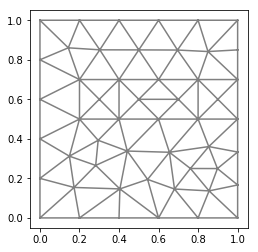

In [52]:
plot(mesh)

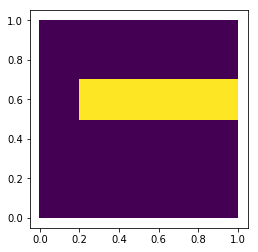

In [55]:
plot(domains)

In [14]:
a0 = 1.0
a1 = 0.01
x = SpatialCoordinate(mesh)
g_L = exp(- 10*(- pow(x[1] - 0.5, 2)))
g_R = 1.0
f = 1.0

In [15]:
# Define function space and basis functions
V = FunctionSpace(mesh, ("CG", 2))
u = TrialFunction(V)
v = TestFunction(V)

In [16]:
u5 = Function(V)
with u5.vector().localForm() as bc_local:
    bc_local.set(5.0)

u0 = Function(V)
with u0.vector().localForm() as bc_local:
    bc_local.set(0.0)

In [58]:
# Define Dirichlet boundary conditions at top and bottom boundaries
bcs = [DirichletBC(V, u5, boundaries.where_equal(2)),
       DirichletBC(V, u0, boundaries.where_equal(4))]

In [18]:
dx = dx(subdomain_data=domains)
ds = ds(subdomain_data=boundaries)

In [19]:
# Define variational form
F = (inner(a0*grad(u), grad(v))*dx(5) + inner(a1*grad(u), grad(v))*dx(6)
     - g_L*v*ds(1) - g_R*v*ds(3)
     - f*v*dx(5) - f*v*dx(6))

In [20]:
# Separate left and right hand sides of equation
a, L = lhs(F), rhs(F)

In [21]:
# Solve problem
u = Function(V)
solve(a == L, u, bcs)

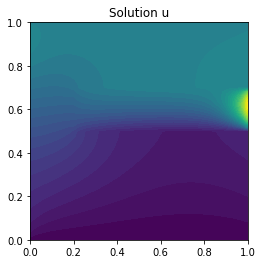

In [22]:
plot(u, title="Solution u")

In [23]:
bb_tree = cpp.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
u([0.5, 0.5], bb_tree)[0]

1.0221479056519496

In [24]:
max(u.vector().array)

11.269341773606898

In [25]:
from numpy import linspace
from matplotlib.pyplot import plot

xval = linspace(0,1,10)

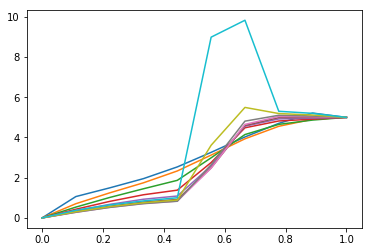

In [26]:
for x in xval:
    yval=[u([x, y], bb_tree)[0] for y in xval]
    plot(xval, yval)

In [18]:
# Evaluate integral of normal gradient over top boundary
n = FacetNormal(mesh)
m1 = dot(grad(u), n)*ds(2)
v1 = assemble_scalar(m1)
print("\int grad(u) * n ds(2) = ", v1)

\int grad(u) * n ds(2) =  0.0


In [19]:
# Evaluate integral of u over the obstacle
m2 = u*dx(1)
v2 = assemble_scalar(m2)
print("\int u dx(1) = ", v2)

\int u dx(1) =  0.4752519801053826


In [21]:
gu=grad(u)
gu

Grad(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Lagrange', triangle, 2)), 8))

In [22]:
#plot(gu, title="Projected grad(u)")